## ボード線図
https://controlabo.com/bode-diagram/

Gain: -20.15dB, Amp: 0.10, Phase: 78.5deg


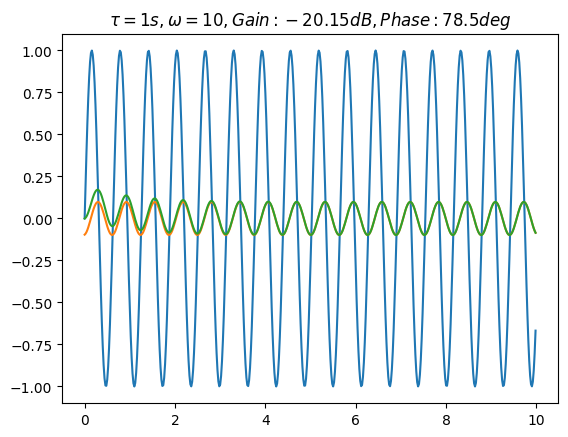

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# モデル設定
tau = 1
omega = 10

dt = 0.02
beta = dt / (tau + dt)
t = np.arange(0, 10, dt)
half = len(t) // 2
f = np.sin(omega * t)

def calc_first_order(f, beta):
  y = np.empty_like(f)
  for i in range(len(f)):
    y[i] = y[i-1] + (f[i] - y[i-1]) * beta if i != 0 else f[i]
  return y

def calc_phase_delay(t, y, omega, amp):
  # 位相遅れを取得
  phases = np.arange(0, 90, 0.5)
  diff = np.full_like(phases, np.nan)
  for i in range(len(phases)):
    deg = phases[i]
    diff[i] = np.abs(y - amp * np.sin(omega * t - deg *np.pi / 180)).sum()
  return phases[np.argmin(diff)]

y = calc_first_order(f, beta)

amp = np.abs(y[half:]).mean() / np.abs(f[half:]).mean()
gain = 20 * np.log10(amp)

deg = calc_phase_delay(t[half:], y[half:], omega, amp)

print(f"Gain: {gain:.2f}dB, Amp: {amp:.2f}, Phase: {deg:.1f}deg")
plt.title(rf"$\tau = 1s, \omega = 10, Gain: {gain:.2f}dB, Phase: {deg:.1f}deg$")

steady_state = amp * np.sin(omega * t - deg *np.pi / 180)
plt.plot(t, f)
plt.plot(t, steady_state)
plt.plot(t, y)
plt.show()

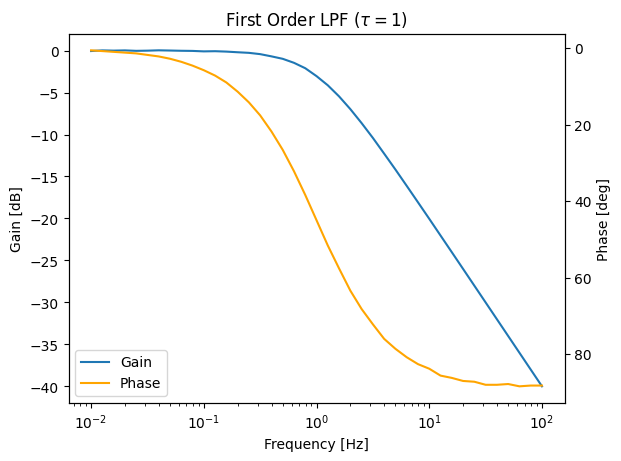

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from numba import jit, prange

# モデル設定
dt = 5e-4
tau = 1
alfa = tau / (tau + dt)

x_low = -2
x_high = 2
x_slice = 10
num = x_slice * (x_high - x_low) + 1
exp = np.logspace(x_low, x_high, num)

@jit(nopython=True, cache=True, fastmath=True, nogil=True)
def calc_first_order(f, alfa):
  y = np.empty_like(f)
  y[0] = f[0]
  for i in range(1, len(f)):
    y[i] = alfa * y[i-1] + (1 - alfa) * f[i]
  return y

@jit(nopython=True, cache=True, parallel=True, fastmath=True, nogil=True)
def calc_amp(f, y):
  return np.abs(y).mean() / np.abs(f).mean()

@jit(nopython=True, cache=True, parallel=True, fastmath=True, nogil=True)
def calc_phase_delay(t, y, omega):
  # 位相遅れを取得
  phases = np.arange(0, 90, 0.2)
  diff = np.empty_like(phases)
  for i in prange(len(phases)):
    deg = phases[i]
    rad = deg * np.pi / 180
    ref = np.sin(omega * t - rad)
    diff[i] = np.abs(y - ref).sum()
  return phases[np.argmin(diff)]

@jit(nopython=True, cache=True, parallel=True, fastmath=True, nogil=True)
def f(exp, alfa, dt):
  t = np.arange(0, 800, dt)
  half = len(t) // 4 * 3
  amp = np.empty_like(exp)
  theta = np.empty_like(exp)
  for j in prange(len(exp)):
    omega = exp[j]
    f = np.sin(omega * t)
    y = calc_first_order(f, alfa)
    amp[j] = calc_amp(f[half:], y[half:])
    theta[j] = calc_phase_delay(t[half:], y[half:], omega)
  gain = 20 * np.log10(amp)
  return [amp, gain, theta]

[amp, gain, theta] = f(exp, alfa, dt)

plt.figure()
plt.title(r"First Order LPF ($\tau=1$)")
plt.gca().set_xscale('log')
# plt.plot(exp, amp, label="amp")
plt.plot(exp, gain, label="Gain")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Gain [dB]")

ax = plt.gca()
ax2 = plt.gca().twinx()
ax2.plot(exp, theta, label="Phase", color="orange")
ax2.set_ylabel("Phase [deg]")
ax2.invert_yaxis()

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2, loc="lower left")

plt.show()